# Simulate some data to test the method.

In [16]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from tqdm import tqdm, trange

plotpar = {'axes.labelsize': 30,
           'font.size': 30,
           'legend.fontsize': 30,
           'xtick.labelsize': 30,
           'ytick.labelsize': 30,
           'text.usetex': True}
plt.rcParams.update(plotpar)

import read_mist_models
from isochrones.mist import MIST_Isochrone
from isochrones import StarModel

from stardate.lhf import gyro_model_rossby, gyro_model, sigma, calc_rossby_number

bands = ["B", "V", "J", "H", "K", "BP", "RP", "G"]
mist = MIST_Isochrone(bands)
mist.initialize()

Draw randomly from mass, age, metallicity, distance and extinction distributions. Use isochrones model to predict $T_\mathrm{eff}$, observed metallicity, $\hat{F}$, apparent magnitudes $J$, $H$, $K$, $B$, $V$, $\log(g)$ and parallax. Use Gyrochronology model to predict rotation period from age and $B$-$V$ color.

In [56]:
def color_err(c):
    c_err = np.zeros(len(c))
    bright = c < 13
    medium = (13 < c) * (c < 17)
    faint = 17 <= c
    c_err[bright] = np.ones(len(c_err[bright]))*.002
    c_err[medium] = np.ones(len(c_err[medium]))*.01
    c_err[faint] = np.ones(len(c_err[faint]))*.2
    return c_err


def photometric_noise(G, bp, rp):
    G_err = np.zeros(len(G))
    bright = G < 13
    medium = (13 < G) * (G < 17)
    faint = 17 <= G
    G_err[bright] = np.ones(len(G_err[bright]))*.0003
    G_err[medium] = np.ones(len(G_err[medium]))*.002
    G_err[faint] = np.ones(len(G_err[faint]))*.01

    bp_err = color_err(bp)
    rp_err = color_err(rp)
    
    parallax_err = np.zeros(len(G))
    bright = G < 15
    medium = (15 < G) * (G < 17)
    faint = (17 < G) * (G < 20)
    ultra_faint = 20 <= G
    parallax_err[bright] = .03  # milliarcseconds
    parallax_err[medium] = .1
    parallax_err[faint] = .7
    parallax_err[ultra_faint] = 2
    
    return G_err, bp_err, rp_err, parallax_err


def log_error_abs(x, dx):
    return dx / x*np.log(10)

def log_error(rel_errx):
    return rel_errx / np.log(10)


def generate_df(N=1000, with_noise=False, period_uncertainty=.1):
    """
    Simulate stellar properties from an distribution of EEPss, ages, 
    metallicities, distances and extinctions.
    """

    np.random.seed(42)
    eep = np.random.uniform(195, 480, size=N)
    age = np.log10(np.random.uniform(.5, 14, size=N)*1e9)
    feh = np.random.uniform(-.2, .2, size=N)
    mass = mist.interp_value([eep, age, feh], ["mass"])
    d_kpc = np.random.uniform(.01, 1, size=N)
    d_pc = d_kpc*1e3
    av = np.random.uniform(0, .1, size=N)

    # Save as a pandas data frame
    df = pd.DataFrame(dict({"eep": eep, "age": age, "feh": feh, "d_kpc": d_kpc, "Av": av}))
    
    logg, teff, feh_interp, B, V, J, H, K, BP, RP, G, logL = [np.zeros(N) for i in range(12)]
    print("Calculating stellar parameters...")
    for i in trange(N):
        teff[i], logg[i], feh_interp[i], bands = mist.interp_mag(
            [eep[i], age[i], feh[i], d_pc[i], av[i]], 
            ["B", "V", "J", "H", "K", "BP", "RP", "G"])
        B[i], V[i], J[i], H[i], K[i], BP[i], RP[i], G[i] = bands
        logL[i] = mist.interp_value([eep[i], age[i], feh[i]], ["logL"])[0]
    parallax = 1./d_kpc
    
    G_err, bp_err, rp_err, parallax_err = photometric_noise(G, BP, RP)
    df["BP_err"] = bp_err
    df["RP_err"] = rp_err
    df["G_err"] = G_err
    df["parallax_err"] = parallax_err
    
    df["B_err"] = np.ones_like(N)*.01
    df["V_err"] = np.ones_like(N)*.01
    df["J_err"] = np.ones_like(N)*.01
    df["H_err"] = np.ones_like(N)*.01
    df["K_err"] = np.ones_like(N)*.01
    df["teff_err"] = np.ones_like(N)*25
    df["logg_err"] = np.ones_like(N)*.01
    df["feh_err"] = np.ones_like(N)*.01
        
    if with_noise:
        np.random.seed(42)
        B += np.random.randn(N)*df["B_err"]
        V += np.random.randn(N)*df["V_err"]
        J += np.random.randn(N)*df["J_err"] 
        K += np.random.randn(N)*df["H_err"]
        H += np.random.randn(N)*df["K_err"]
        BP += np.random.randn(N)*df["BP_err"]
        RP += np.random.randn(N)*df["RP_err"]
        G += np.random.randn(N)*df["G_err"]
        teff += np.random.randn(N)*df["teff_err"]
        logg += np.random.randn(N)*df["logg_err"]
        feh += np.random.randn(N)*df["feh_err"]
        parallax += np.random.randn(N)*df["parallax_err"]
        
        
    df["BV"], df["B"], df["V"], df["jmag"], df["hmag"], df["kmag"] = B - V, B, V, J, H, K
    df["BP"], df["RP"], df["G"] = BP, RP, G
    df["logg"], df["teff"], df["logL"], df["parallax"] = logg, teff, logL, parallax
    df["mass"] = mist.mass(df.eep, df.age, df.feh)
    
    # Calculate periods. NaNs will appear for stars with B-V < 0.45
    np.random.seed(42)
    log_prot, prot_err, log_prot_praesepe, prot_err_praesepe = [np.empty(N) for i in range(4)]
    log_prot_scatter, log_prot_scatter_praesepe = [np.empty(N) for i in range(2)]
    print("Calculating rotation periods...")
    for i in trange(N):
        params = [eep[i], age[i], feh[i], d_pc[i], av[i]]
        lpa, siga = gyro_model_rossby(params, rossby=True, Ro_cutoff=2, model="angus15")
        log_prot[i] = lpa
        lpa, sigp = gyro_model_rossby(params, rossby=True, Ro_cutoff=2, model="praesepe")
        log_prot_praesepe[i] = lpa
    
        # Add variance to these.
        log_scattera = np.random.randn(1)*siga + np.random.randn(1)*period_uncertainty*.434
        log_prot_scatter[i] = log_prot[i] + log_scattera
        log_scatterp = np.random.randn(1)*sigp + np.random.randn(1)*period_uncertainty*.434
        log_prot_scatter_praesepe[i] = log_prot_praesepe[i] + log_scatterp
    

    df["prot"] = 10**log_prot_scatter
    df["prot_praesepe"] = 10**log_prot_scatter_praesepe
    df["prot_clean"] = 10**log_prot
    df["prot_clean_prasepe"] = 10**log_prot_praesepe
    df["prot_err"] = df["prot"]*period_uncertainty
    df["prot_err_praesepe"] = df["prot_praesepe"]*period_uncertainty
    df["Ro"] = calc_rossby_number(df.prot, df.mass)
    df["Ro_praesepe"] = calc_rossby_number(df.prot_praesepe, df.mass)

    # Cut unphysical masses
    finite_mask = np.isfinite(df.mass.values)
    finite_df = df.iloc[finite_mask]
    print(len(df.mass.values), "stars originally, ", len(df.mass.values[finite_mask]), "after cuts")
        
    finite_df["ID"] = range(len(finite_df))

    return finite_df

In [57]:
df10 = generate_df(1000)
df5 = generate_df(period_uncertainty=.05)
df1 = generate_df(period_uncertainty=.1)

100%|██████████| 1000/1000 [00:00<00:00, 11511.71it/s]
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in less
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater_equal
  app.launch_new_instance()
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.
/anacon

Calculating stellar parameters...
Calculating rotation periods...


100%|██████████| 1000/1000 [00:00<00:00, 3936.99it/s]
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  0%|          | 0/1000 [00:00<?, ?it/s]

1000 stars originally,  841 after cuts
Calculating stellar parameters...
Calculating rotation periods...


 41%|████      | 411/1000 [00:00<00:00, 4102.16it/s]

1000 stars originally,  841 after cuts
Calculating stellar parameters...
Calculating rotation periods...


100%|██████████| 1000/1000 [00:00<00:00, 4019.40it/s]


1000 stars originally,  841 after cuts


Plot the simulated data on an HR diagram.

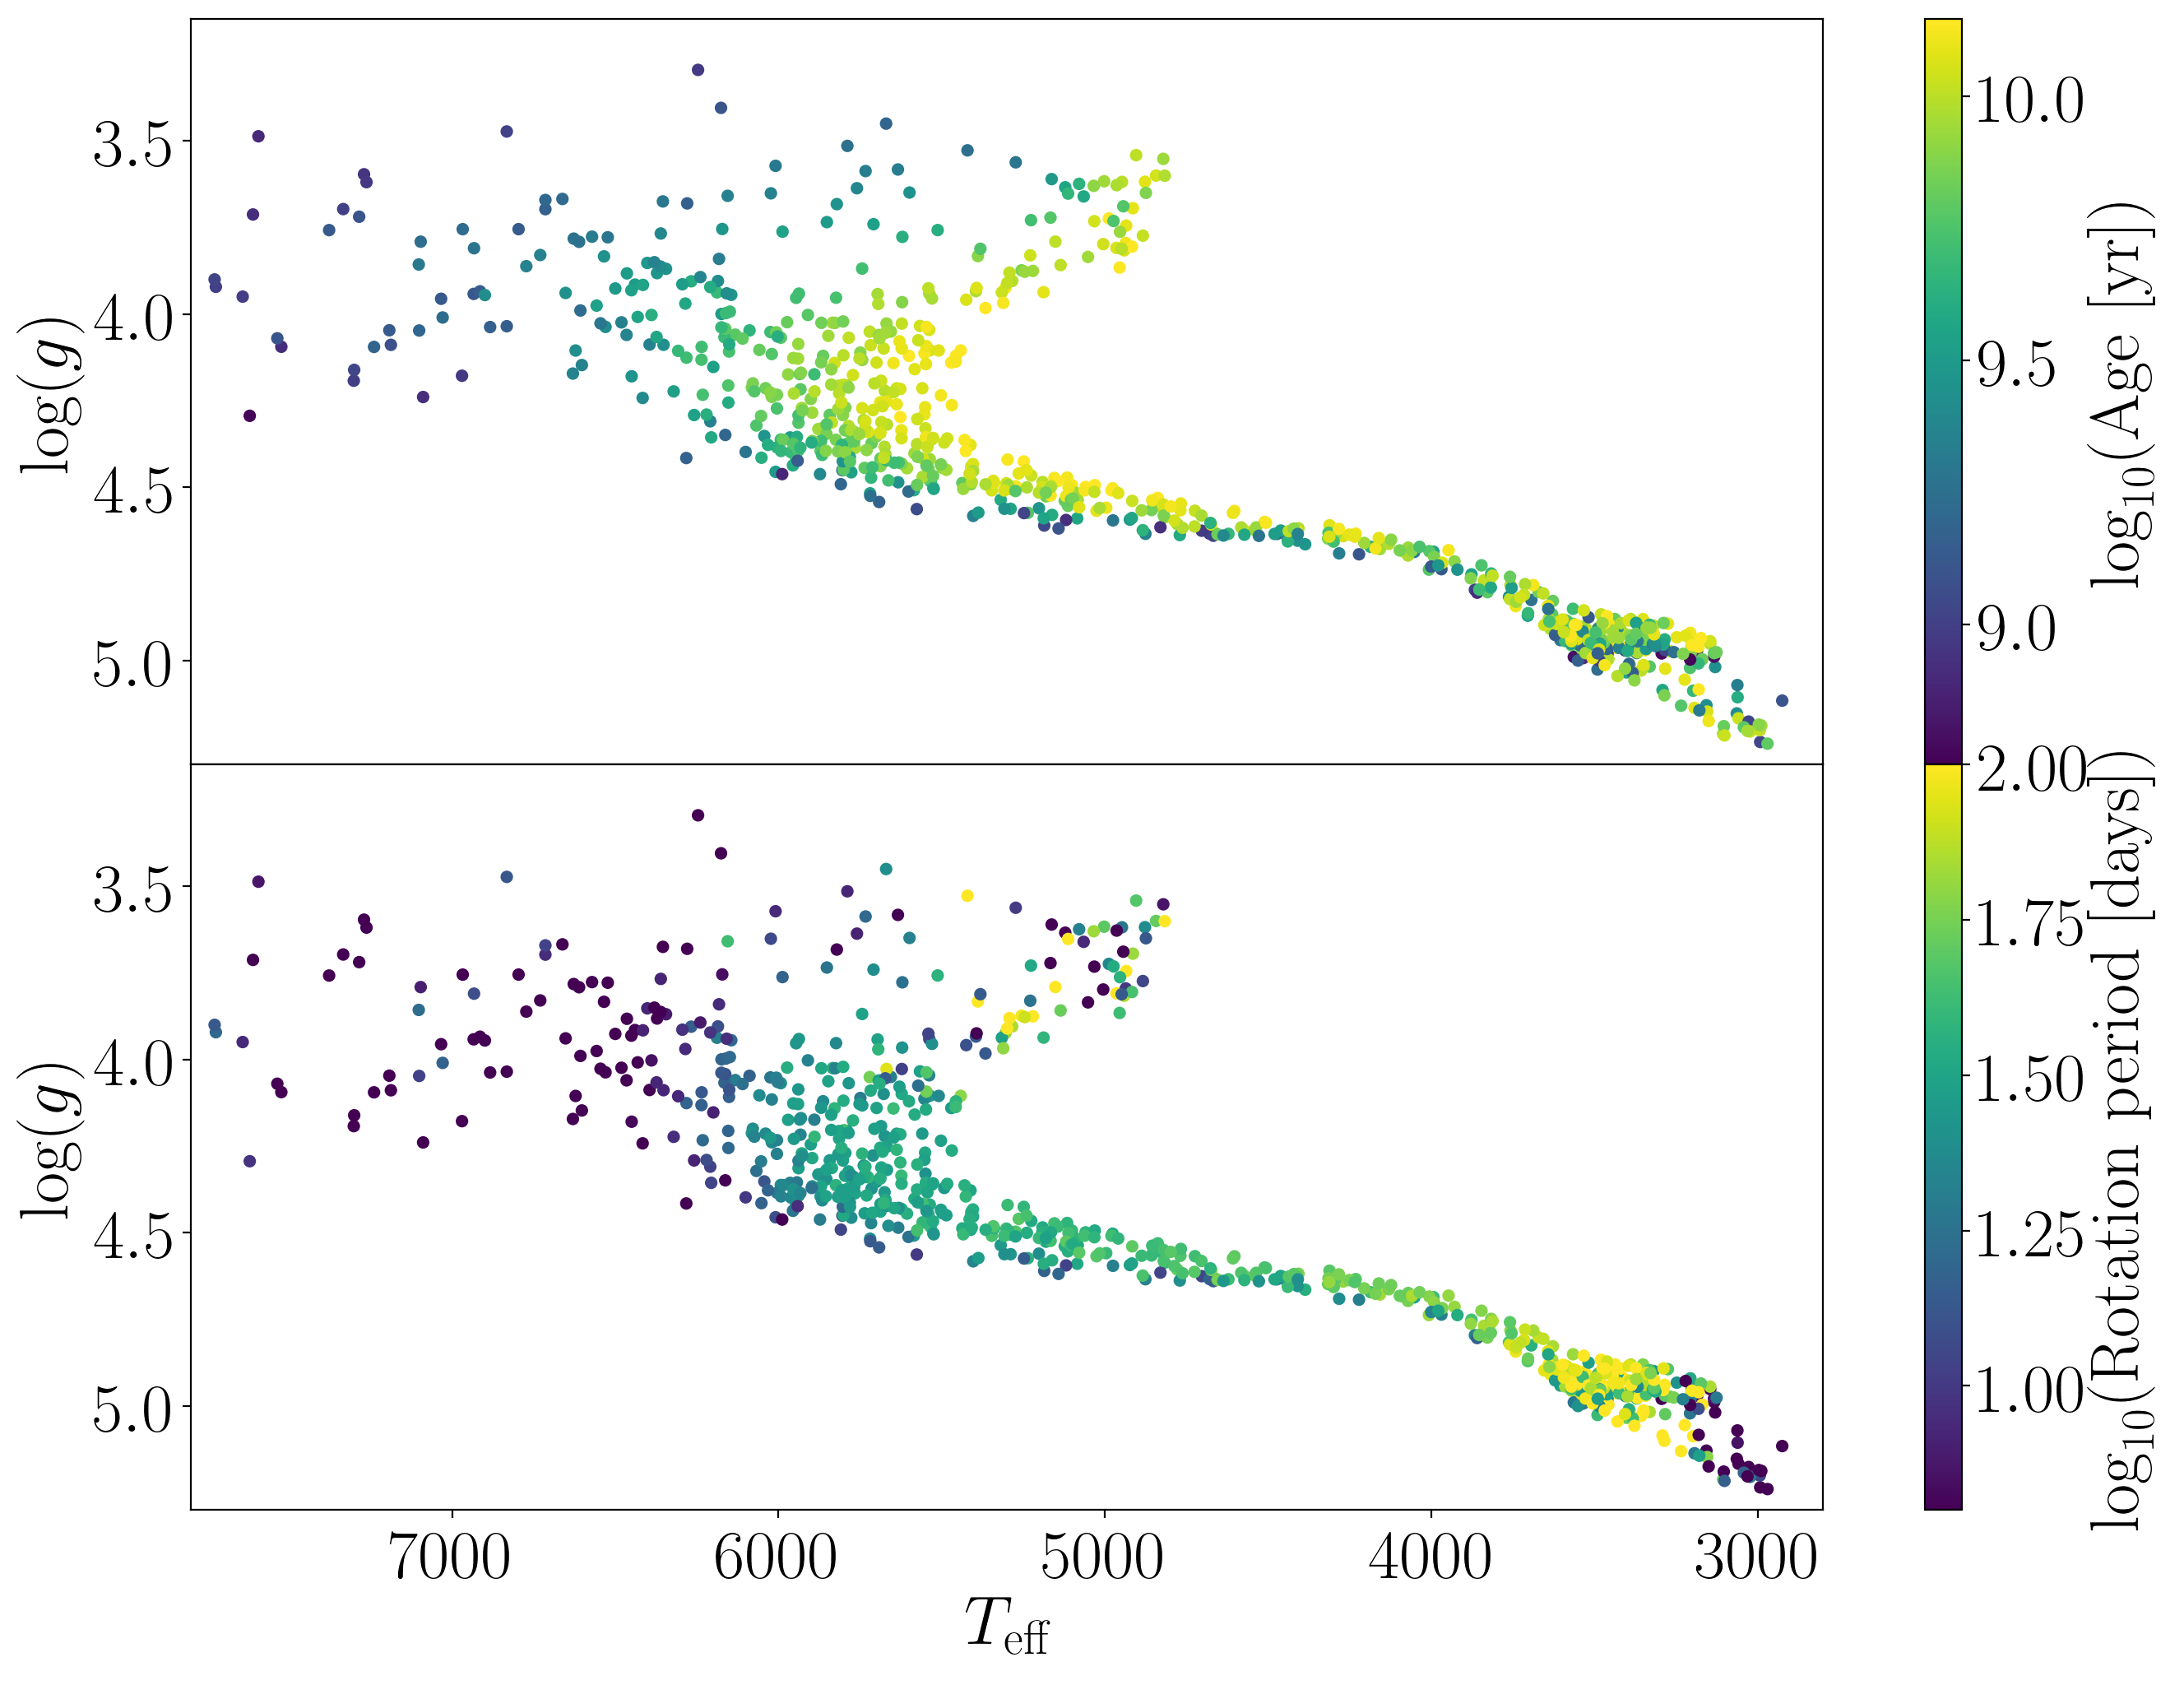

In [58]:
plt.figure(figsize=(16, 12), dpi=200)

plt.subplot(2, 1, 1)
plt.scatter(df1.teff, df1.logg, c=df1.age, s=20)
plt.colorbar(label="$\log_{10}(\mathrm{Age~[yr]})$")
plt.xlim(7800, 2800)
plt.ylim(5.3, 3.15)
plt.xlabel("$T_{\mathrm{eff}}$")
plt.ylabel("$\log(g)$")

plt.subplot(2, 1, 2)
plt.scatter(df1.teff, df1.logg, c=np.log10(df1.prot_praesepe), s=20, vmax=2, vmin=.8)
plt.colorbar(label="$\log_{10}(\mathrm{Rotation~period~[days]})$")
plt.xlim(7800, 2800)
plt.ylim(5.3, 3.15)
plt.xlabel("$T_{\mathrm{eff}}$")
plt.ylabel("$\log(g)$")
plt.subplots_adjust(hspace=0)
plt.savefig("../simulated_CMD.pdf")

Save simulated data file.

In [59]:
df1.to_csv("data/simulated_data1.csv")
df5.to_csv("data/simulated_data5.csv")
df10.to_csv("data/simulated_data10.csv")

Plot the rotation periods.

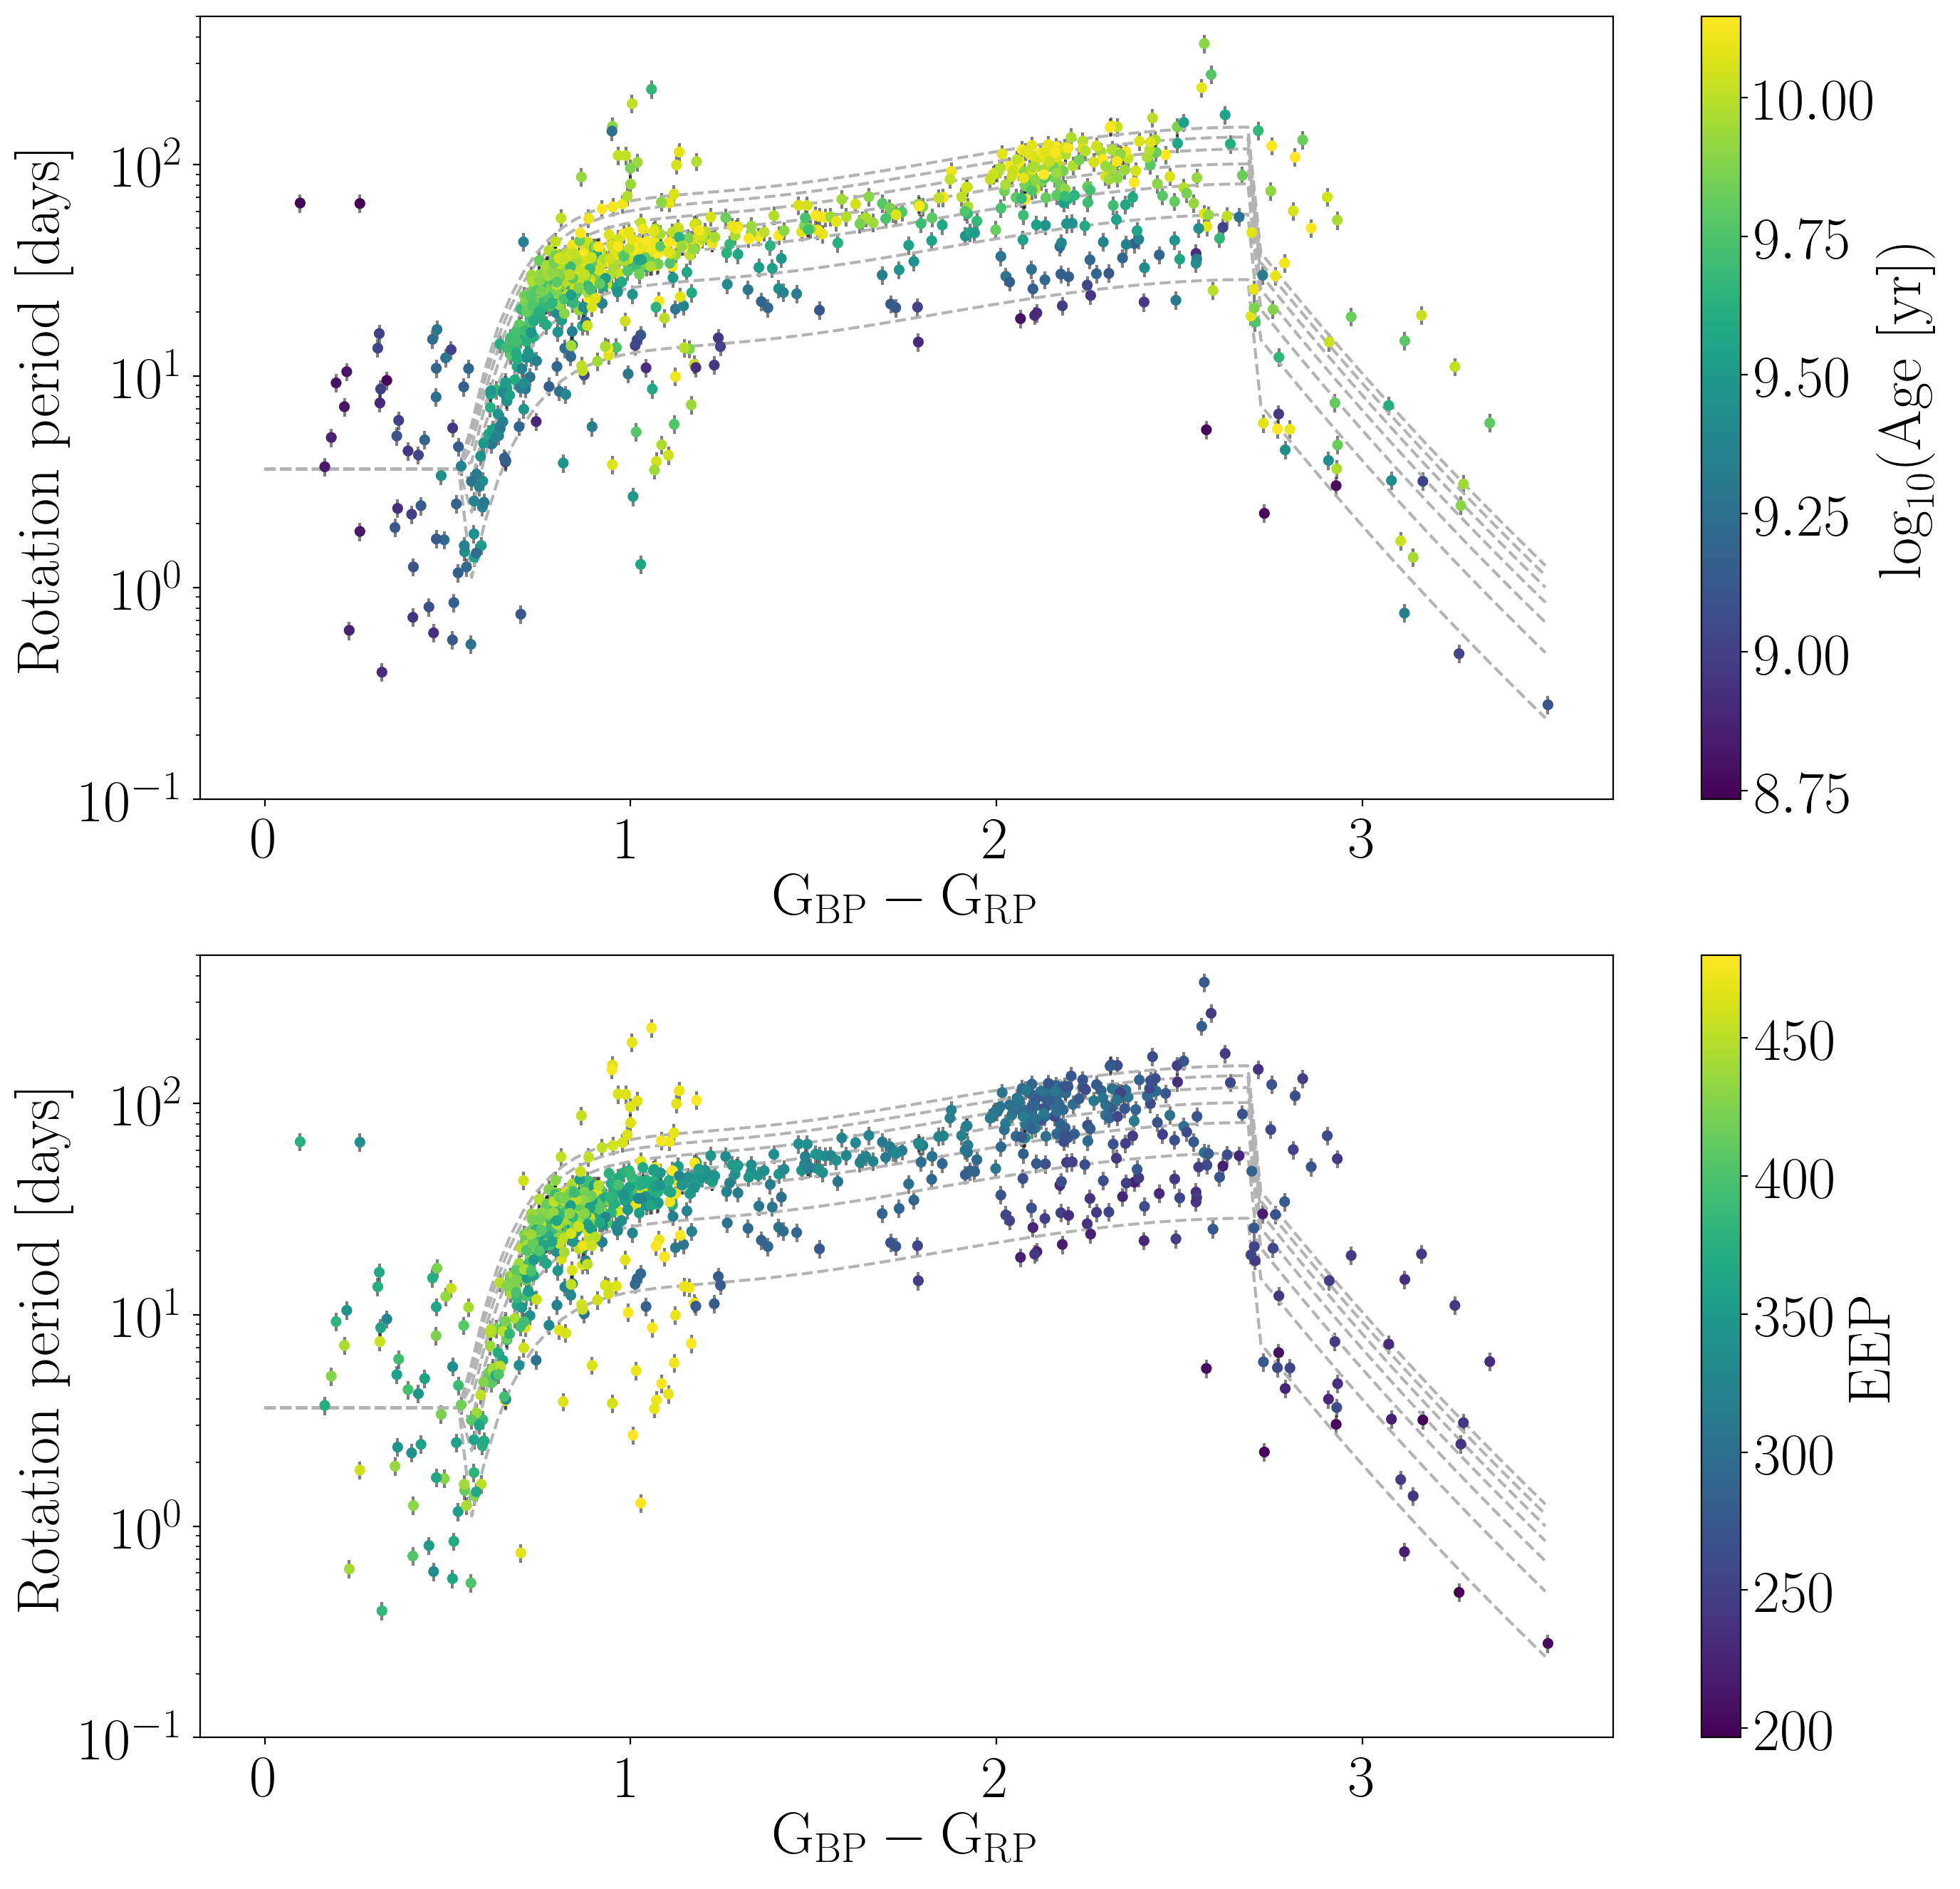

In [34]:
plt.figure(figsize=(16, 16), dpi=200)
from stardate.lhf import gyro_model_praesepe

plt.subplot(2, 1, 1)
# Plot models
bprp = np.linspace(.1, 4, 100)
for a in range(1, 14, 2):
    xs, ps = np.linspace(0, 3.5, 100), []
    for x in xs:
        ps.append(gyro_model_praesepe(np.log10(a*1e9), x))
    plt.plot(xs, 10**np.array(ps), color=".7", ls="--", zorder=0)

plt.errorbar(df.BP-df.RP, df.prot_praesepe, yerr=df.prot_err_praesepe,
             fmt="k.", zorder=0, alpha=.5, rasterized=True)
plt.scatter(df.BP-df.RP, df.prot_praesepe, c=df.age, s=20, zorder=1,
           rasterized=True)
plt.colorbar(label="$\log_{10}(\mathrm{Age~[yr]})$")
plt.xlabel("$\mathrm{G_{BP} - G_{RP}}$")
plt.ylabel("$\mathrm{Rotation~period~[days]}$")
plt.yscale("log")
plt.ylim(.1, 500)
# plt.ylim(.1, 120)


plt.subplot(2, 1, 2)
for a in range(1, 14, 2):
    xs, ps = np.linspace(0, 3.5, 100), []
    for x in xs:
        ps.append(gyro_model_praesepe(np.log10(a*1e9), x))
    plt.plot(xs, 10**np.array(ps), color=".7", ls="--", zorder=0)

plt.errorbar(df.BP-df.RP, df.prot_praesepe, yerr=df.prot_err_praesepe,
             fmt="k.", zorder=0, alpha=.5, rasterized=True)
plt.scatter(df.BP-df.RP, df.prot_praesepe, c=df.eep, s=20, zorder=1,
           rasterized=True)
plt.colorbar(label="$\mathrm{EEP}$")
plt.xlabel("$\mathrm{G_{BP} - G_{RP}}$")
plt.ylabel("$\mathrm{Rotation~period~[days]}$")
plt.yscale("log")
plt.ylim(.1, 500)
# plt.ylim(.1, 120)

plt.subplots_adjust(hspace=.2)
plt.savefig("../rotation_model_praesepe.pdf")

# Now let's make a plot of the model.

In [ ]:
large_df = generate_df(1000000)

  0%|          | 2474/1000000 [00:00<01:20, 12356.36it/s]

Calculating stellar parameters...


 86%|████████▌ | 861072/1000000 [00:59<00:09, 14578.44it/s]

/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


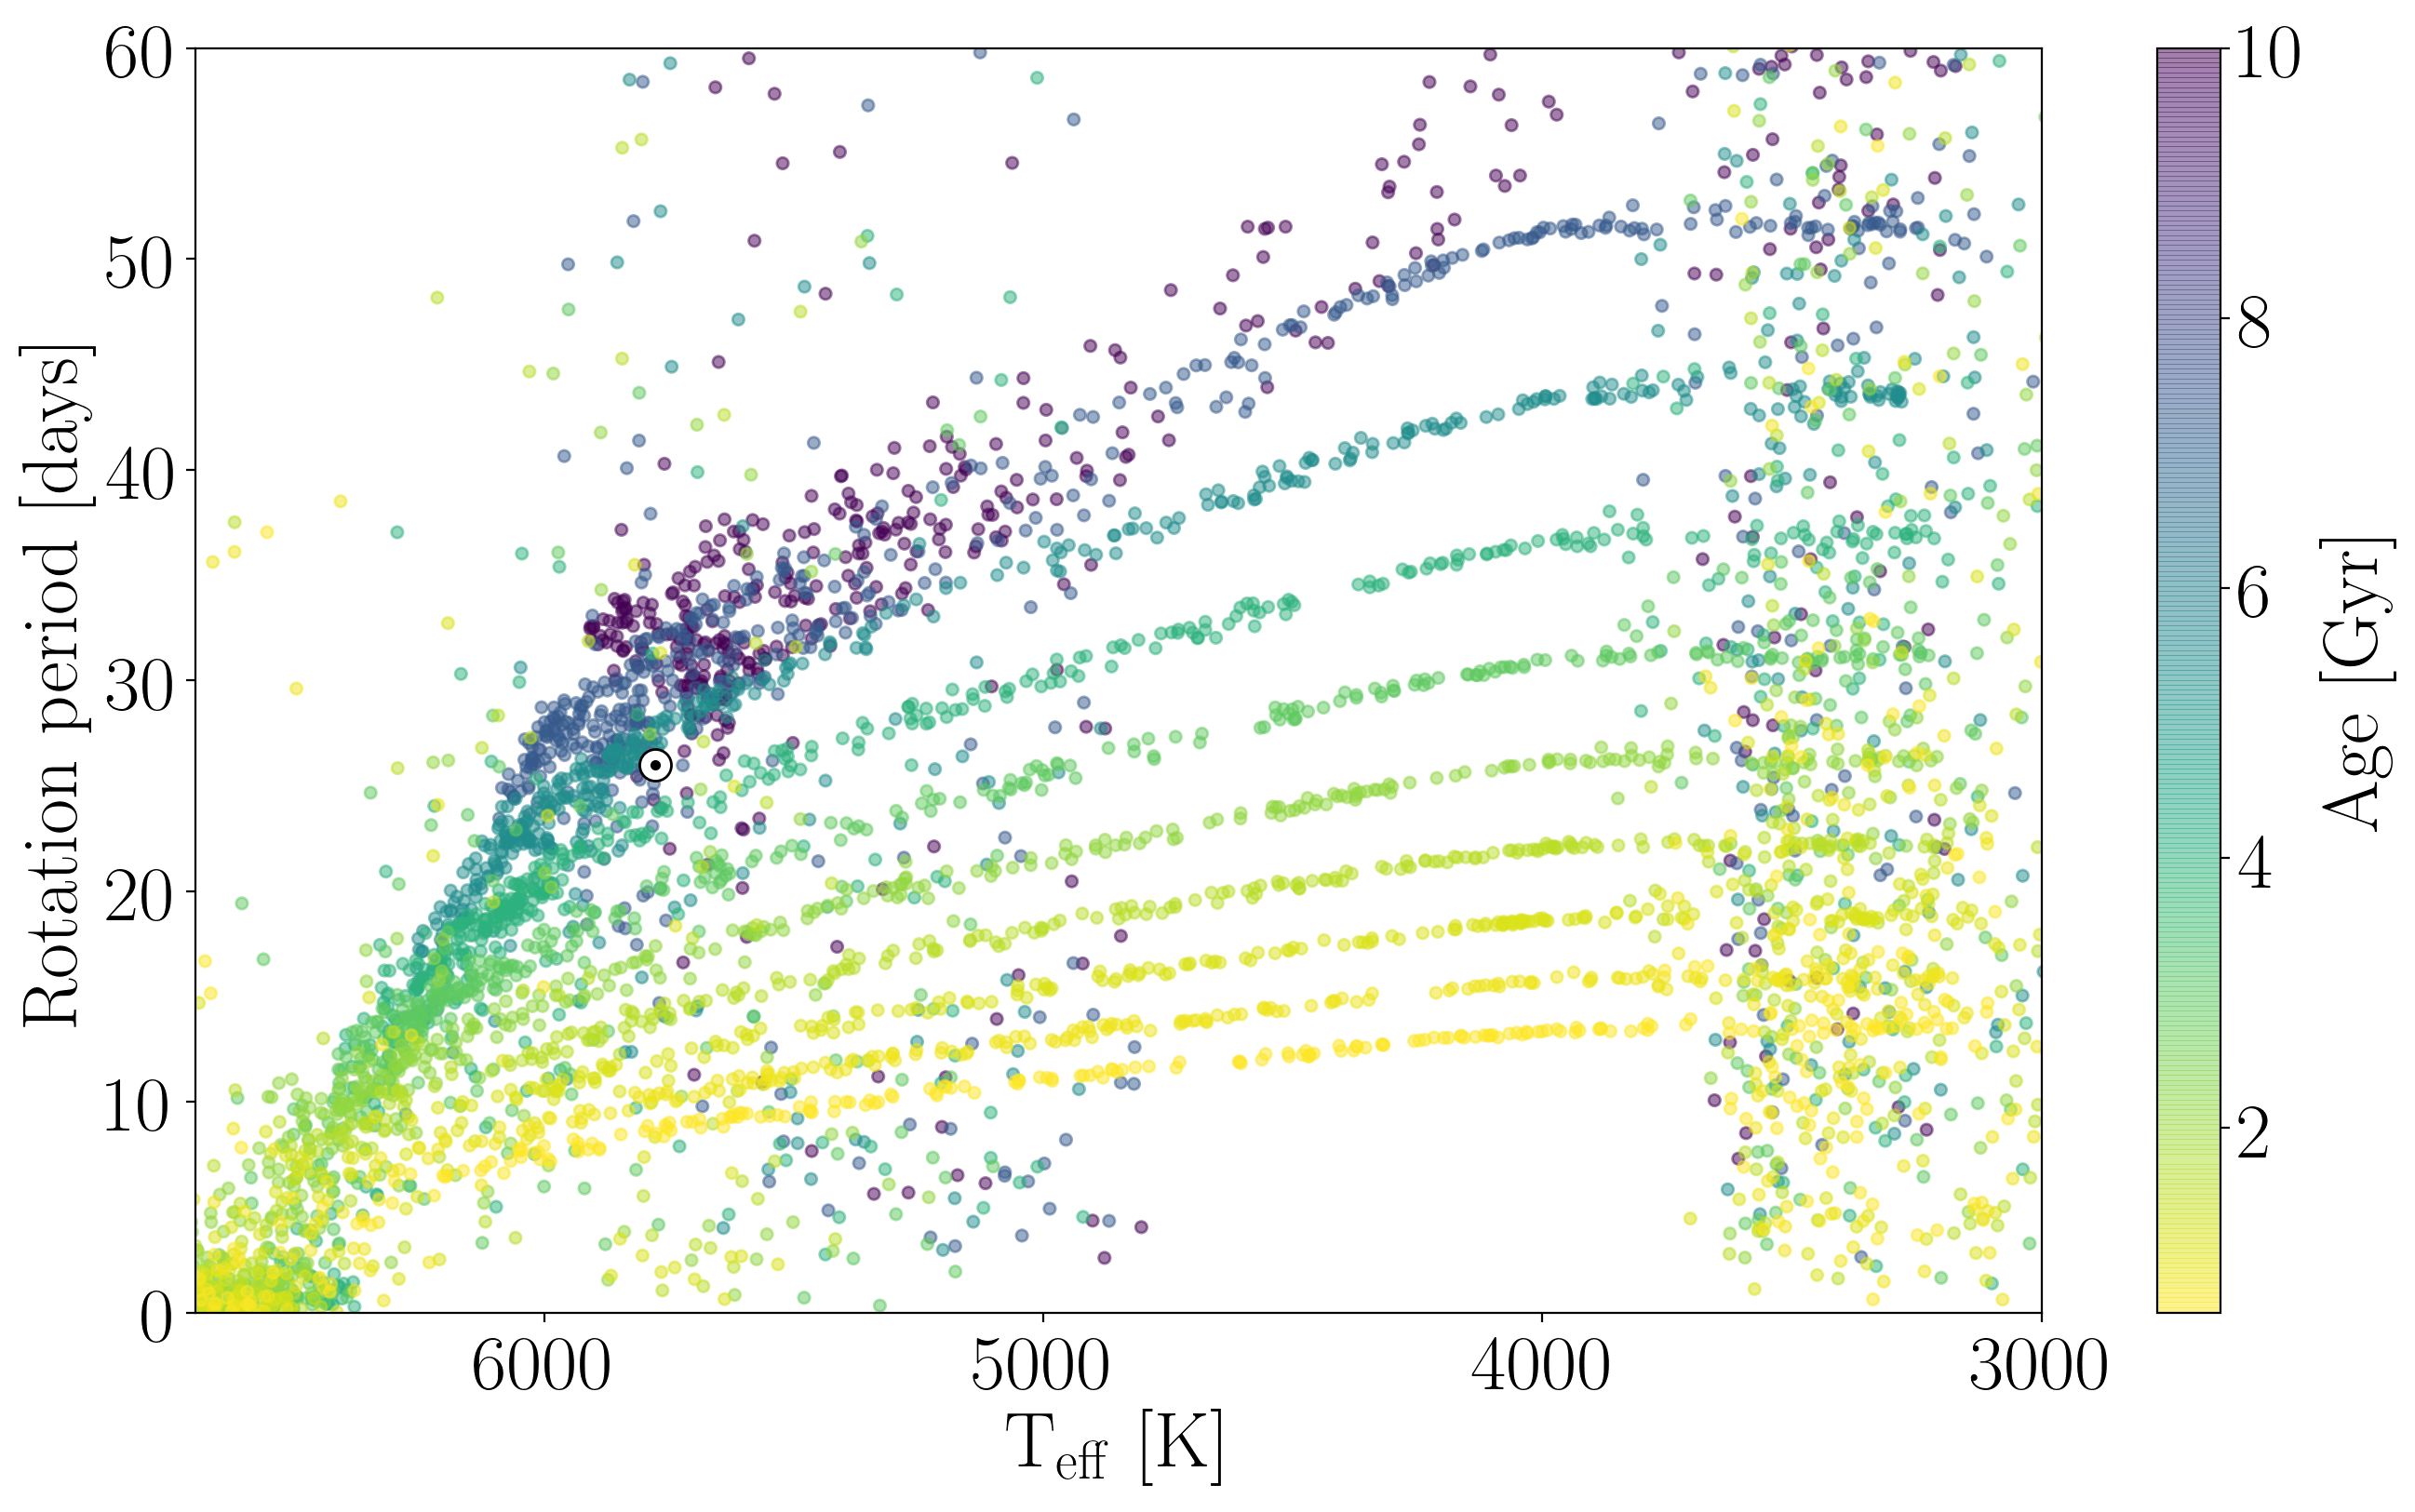

In [69]:
plt.figure(figsize=(16, 9), dpi=200)

def gyr(log10_age):
    return (10**log10_age)*1e-9

for i in np.linspace(10, 8.8, 10):
    m = (gyr(i) < gyr(large_df.age)) * (gyr(large_df.age) < gyr(i) + .01)
    plt.scatter(large_df.teff[m], 10**np.log10(large_df.prot[m]), c=gyr(large_df.age)[m],
                vmin=gyr(8.8), vmax=10, s=20, alpha=.5, cmap="viridis_r", rasterized=True)
plt.colorbar(label="$\mathrm{Age~[Gyr]}$")

# Sun
plt.scatter(5778, 26, facecolors='w', edgecolors="k", s=150, zorder=3, rasterized=True)
plt.plot(5778, 26, "k.", zorder=3, rasterized=True)

# plt.plot(5779, 26, "*", color="C1", markeredgecolor="k", ms=20)
plt.xlim(6700, 3000)
plt.ylim(0, 60)
plt.xlabel("$\mathrm{T_{eff}~[K]}$")
plt.ylabel("$\mathrm{Rotation~period~[days]}$")
plt.savefig("../gyro_model.pdf")
plt.savefig("gyro_model")

And plot a model of the variance.

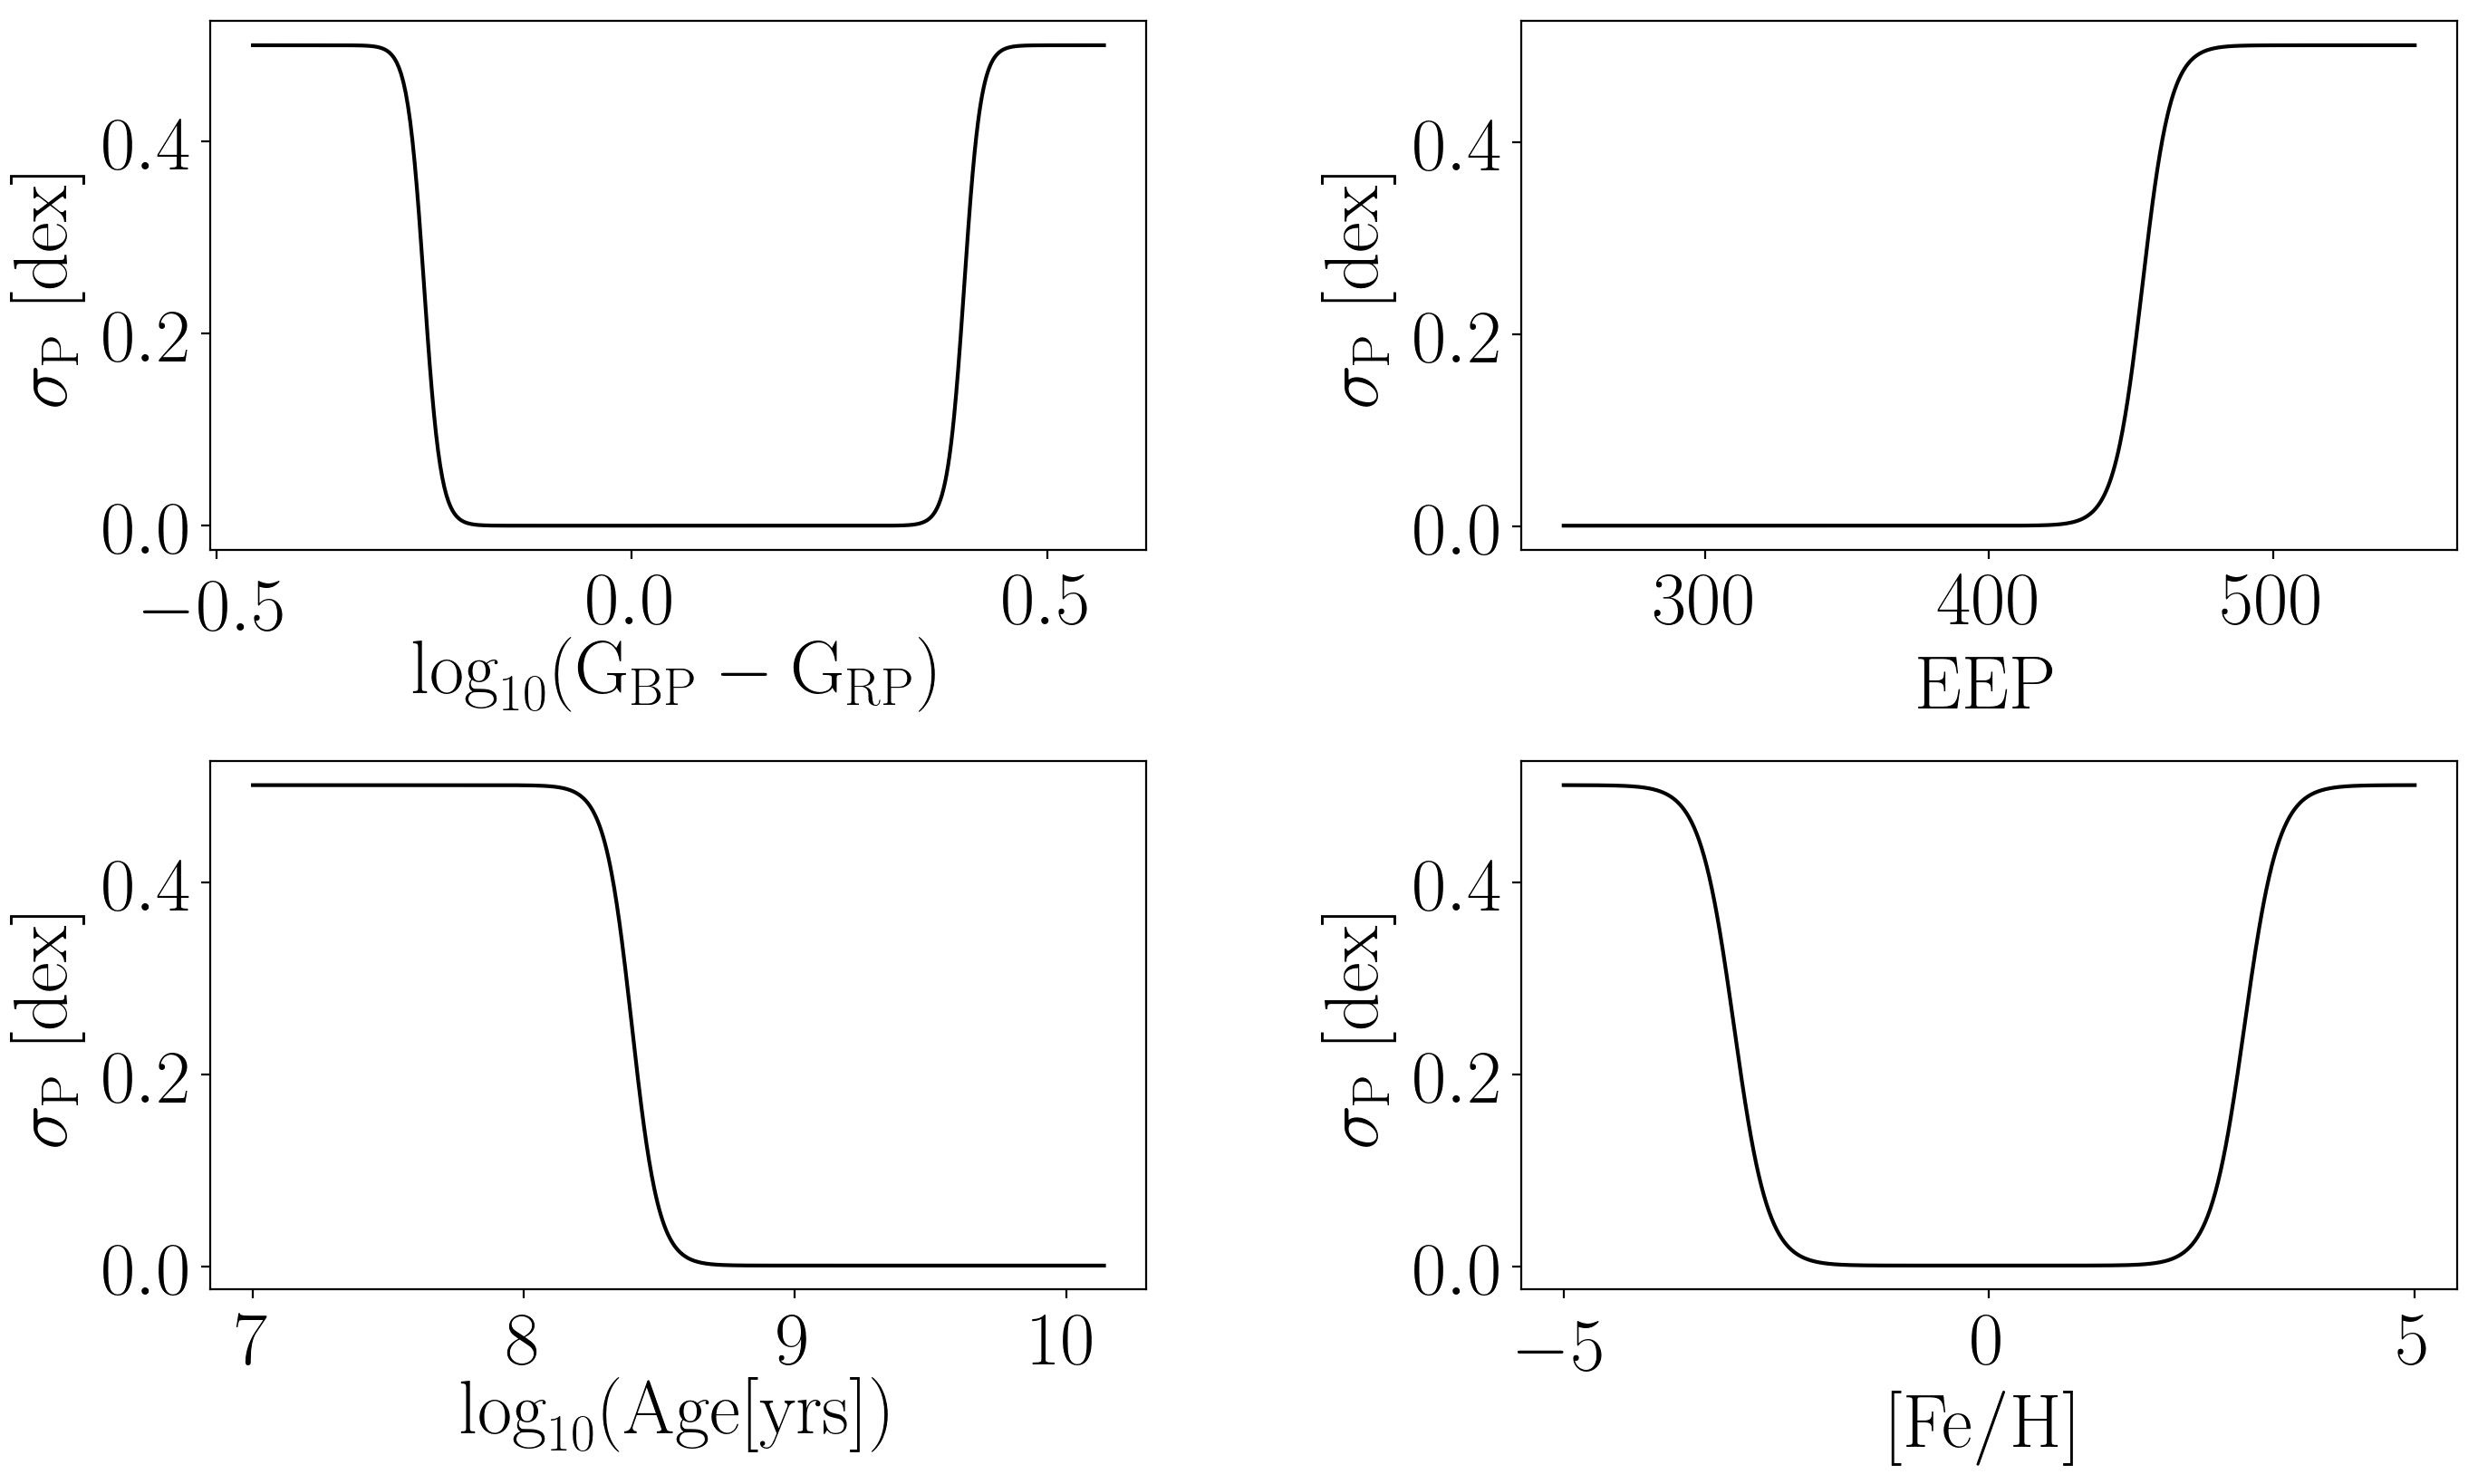

In [46]:
from stardate.lhf import sigma

nplot = 1000
bprps = np.linspace(.35, 3.7, nplot)
eeps = np.linspace(250, 550, nplot)
ages = np.linspace(7, 10.14, nplot)
fehs = np.linspace(-5, 5, nplot)

plt.figure(figsize=(16, 10), dpi=200)

plt.subplot(2, 2, 1)
sigs = [sigma(355, 9, 0, bprp, model="praesepe") for bprp in bprps]
plt.plot(np.log10(bprps), sigs, "k", rasterized=True)
plt.xlabel("$\log_{10}(\mathrm{G_{BP} - G_{RP}})$")
plt.ylabel("$\mathrm{\sigma_P~[dex]}$")

plt.subplot(2, 2, 2)
sigs = [sigma(eep, 9, 0, .65, model="praesepe") for eep in eeps]
plt.plot(eeps, sigs, "k", rasterized=True)
plt.xlabel("$\mathrm{EEP}$")
plt.ylabel("$\mathrm{\sigma_P~[dex]}$")

plt.subplot(2, 2, 3)
sigs = [sigma(355, age, 0, .65, model="praesepe") for age in ages]
plt.plot(ages, sigs, "k", rasterized=True)
plt.xlabel("$\mathrm{\log_{10}(Age [yrs])}$")
plt.ylabel("$\mathrm{\sigma_P~[dex]}$")

plt.subplot(2, 2, 4)
sigs = [sigma(355, 9, feh, .65, model="praesepe") for feh in fehs]
plt.plot(fehs, sigs, "k", rasterized=True)
plt.xlabel("$\mathrm{[Fe/H]}$")
plt.ylabel("$\mathrm{\sigma_P~[dex]}$")

plt.subplots_adjust(bottom=.18, wspace=.4, hspace=.4)
plt.savefig("../variance.pdf")
plt.savefig("variance")